## Exercises

n order to master the material of this module, do the following:

* work with a different symbol
* estimate the value of a European put option with the same parameters
* estimate the values of European call/put options for a wide range of strikes
* estimate the values for European options with more exotic payoffs (e.g. lookback features)
* replace the geometric Brownian motion model by a more realistic one with jumps and/or stochastic volatility
* go through the documentation of the library [DX Analytics](http://dx-analytics.com) to learn more about derivatives analytics with Python


In [2]:
import numpy as np  # array operations
import pandas as pd  # time series management
import matplotlib.pyplot as plt  # standard plotting library
from pylab import plt
plt.style.use('ggplot')
# put all plots in the notebook itself
%matplotlib inline

In [3]:
sym = 'AAPL.O'  # our symbol
data = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                   index_col=0, parse_dates=True)[sym]
data = pd.DataFrame(data)

In [5]:
data.tail(2)  

,AAPL.O
Date,
2018-06-28,185.50
2018-06-29,185.11


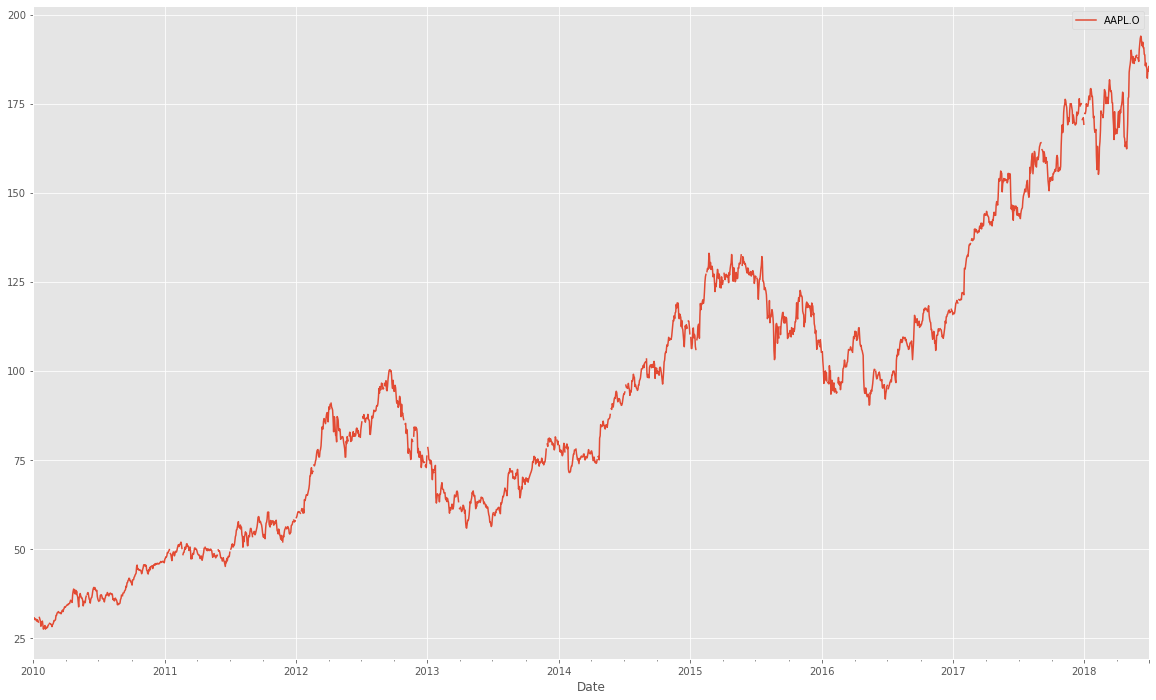

In [6]:
data.plot(figsize=(20, 12));

## Basic Statistics
**annualized stock return and volatility** 

In [8]:
# vectorized calculation of the log returns
log_rets = np.log(data / data.shift(1))
# annualized average log returns
mu = log_rets.mean() * 252
mu

AAPL.O    0.181303
dtype: float64

In [9]:
# annualized volatility
sigma = log_rets.std() * 252 ** 0.5
sigma

AAPL.O    0.25305
dtype: float64

## Stock Price Model
**geometric Brownian motion**


$
dS_t = \mu S_t dt + \sigma  S_t dZ_t
$

with

* $S_t$ being the stock price at date $t$
* $\mu$ being the average return of the stock (drift)
* $\sigma$ the volatility
* $Z_t$ a standard Brownian motion

An Euler discretization scheme is given by

$
S_t = S_{t-\Delta t} e^{ \left( \mu-\frac{1}{2}\sigma^2 \right)\Delta t + \sigma \sqrt{\Delta t} z_t}
$

with $\Delta t$ a fixed time interval and $z_t$ a standard normally distributed random variable.



## Monte Carlo Simulation

In [11]:
S0 = data.iloc[-1]  # final value = initial value
sigma = sigma.values[0]  # volatility of the stock
mu = mu.values[0]  # average return
T = 1.0  # horizon 1 year
M = 252  # number of time intervals
dt = T / M  # fixed length time interval
I = 20000  # number of simulated paths

In [12]:
rand = np.random.standard_normal((M + 1, I))  # radnom number array
S = np.zeros_like(rand)  # array for stock prices
S[0] = S0  # all paths start at initial value
for t in range(1, M + 1):
    S[t] = S[t-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * dt ** 0.5 * rand[t])

(0.0, 252.0)

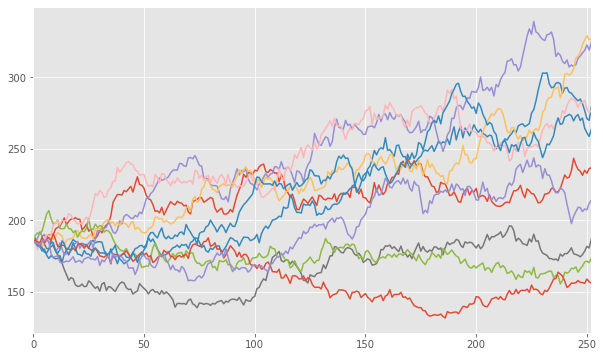

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(S[:, :10]);
plt.xlim(0, M)

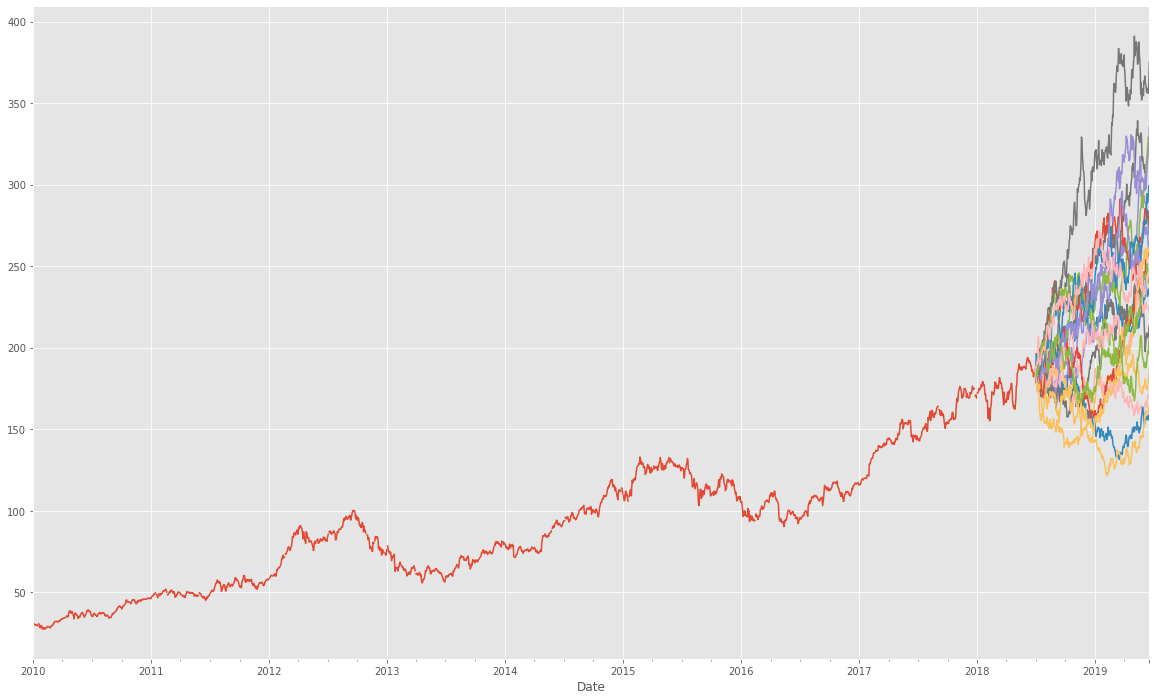

In [15]:
index = pd.date_range(start=data.index[-1], periods=M + 1, freq='B')
ax = data.plot(figsize=(20, 12), legend=False);
pd.DataFrame(S[:, :20], index=index).plot(ax=ax, legend=False);

## Option Pricing
In order to price options by Monte Carlo simulation, we need to **simulate the stochastic process with the drift $\mu$ replaced by the risk-less short rate $r$** (according to the Fundamental Theorem of Asset Pricing).



In [16]:
r = 0.01  # risk-less short rate
for t in range(1, M + 1):
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * dt ** 0.5 * rand[t])

In [17]:
# vectorized payoff calculation
payoff = np.maximum(S[-1] - 110, 0)

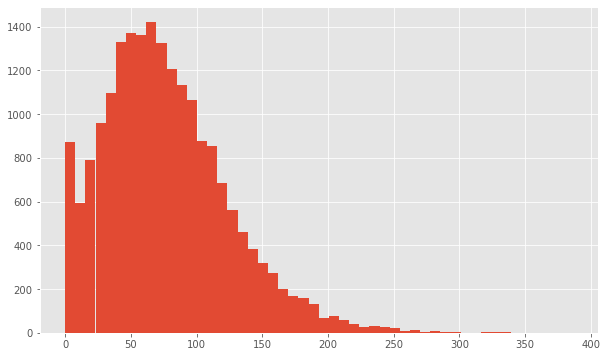

In [18]:
plt.figure(figsize=(10, 6));
plt.hist(payoff, bins=50);

In [19]:
C0 = np.exp(-r * T) * np.sum(payoff) / I
C0  # estimated call option price

76.12100955042567